#BLACKWELL’S APPROACHABILITY

In [ ]:
import numpy as np

class Player:
    def __init__(self, num_actions):
        self.num_actions = num_actions
        self.weights = np.ones(num_actions) / num_actions  # Initial uniform distribution over actions

    def choose_action(self):
        # Choose action based on current weights (probability distribution)
        return np.random.choice(self.num_actions, p=self.weights)

    def update_weights(self, action, loss_vector):
        # Update weights based on the observed loss vector
        total_loss = sum(loss_vector)
        if total_loss == 0:
            return  # No loss, no update needed

        for a in range(self.num_actions):
            if loss_vector[a] > 0:
                self.weights[a] *= np.exp(-loss_vector[a] / total_loss)

        # Normalize weights to maintain a probability distribution
        self.weights /= np.sum(self.weights)

def simulate_game(player, adversary, num_rounds):
    player_regret = 0
    adversary_regret = 0

    for _ in range(num_rounds):
        player_action = player.choose_action()
        adversary_action = adversary.choose_action()

        # Calculate loss vector for both player and adversary
        player_loss = np.zeros(player.num_actions)
        player_loss[adversary_action] = 1

        adversary_loss = np.zeros(adversary.num_actions)
        adversary_loss[player_action] = 1

        # Update player and adversary strategies based on observed losses
        player.update_weights(player_action, adversary_loss)
        adversary.update_weights(adversary_action, player_loss)

        # Accumulate regrets
        player_regret += np.dot(player.weights, adversary_loss)
        adversary_regret += np.dot(adversary.weights, player_loss)

    return player_regret, adversary_regret

# Example usage
num_actions = 3
num_rounds = 1000

player = Player(num_actions)
adversary = Player(num_actions)

player_regret, adversary_regret = simulate_game(player, adversary, num_rounds)

print("Player's regret:", player_regret)
print("Adversary's regret:", adversary_regret)

Player's regret: 241.37634755962299
Adversary's regret: 240.70550062982682


#Vector Losses

In [ ]:
import numpy as np

def vector_loss(predicted_vector, actual_vector):
    """
    Compute the Euclidean distance (L2 norm) between the predicted vector
    and the actual vector of outcomes.

    Args:
    predicted_vector (numpy.ndarray): Predicted vector of outcomes.
    actual_vector (numpy.ndarray): Actual vector of outcomes.

    Returns:
    float: Euclidean distance (L2 norm) between the predicted and actual vectors.
    """
    return np.linalg.norm(predicted_vector - actual_vector)

# Example usage
# Define the predicted and actual vectors
predicted = np.array([0.3, 0.5, 0.2])
actual = np.array([0.2, 0.6, 0.2])

# Calculate vector loss
loss = vector_loss(predicted, actual)
print("Vector Loss:", loss)

Vector Loss: 0.14142135623730948


#Von Neumann Minimax Theorem

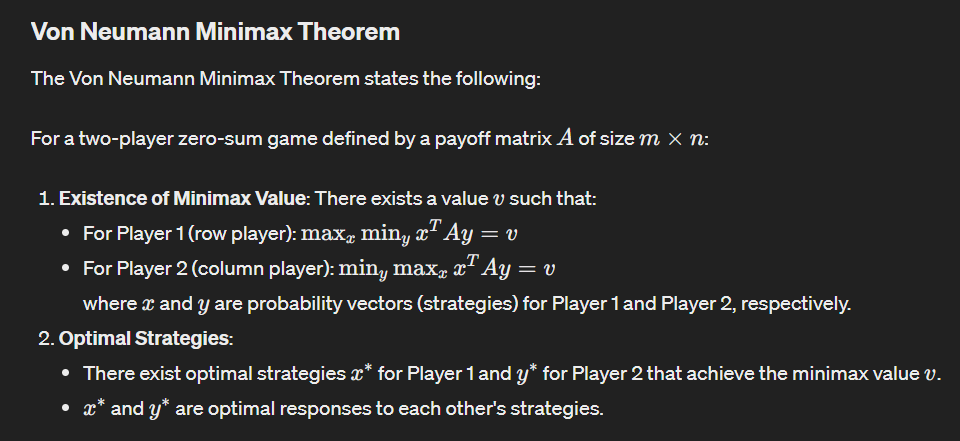

In [ ]:
import numpy as np
from scipy.optimize import linprog

def compute_minimax_value_and_strategy(payoff_matrix):
    """
    Compute the minimax value and optimal strategies for a given two-player zero-sum game.

    Args:
    payoff_matrix (numpy.ndarray): Payoff matrix representing the game.

    Returns:
    float: Minimax value (v).
    numpy.ndarray: Optimal strategy for Player 1 (x*).
    numpy.ndarray: Optimal strategy for Player 2 (y*).
    """
    m, n = payoff_matrix.shape

    # Set up the linear programming problem for Player 1 (maximizing the minimum guarantee)
    c = np.ones(m)  # coefficients for the objective function (to maximize)
    A_ub = -payoff_matrix.T  # transpose of the payoff matrix (inequality constraint)
    b_ub = -np.ones(n)  # right-hand side of the inequality constraint (to minimize)

    # Solve the linear programming problem for Player 1
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, method='highs')
    v = 1 / res.fun  # calculate the minimax value

    # Optimal strategy for Player 1
    x_star = res.x / np.sum(res.x)

    # Set up the linear programming problem for Player 2 (minimizing the maximum loss)
    c = -np.ones(n)  # coefficients for the objective function (to minimize)
    A_ub = payoff_matrix  # payoff matrix (inequality constraint)
    b_ub = np.ones(m)  # right-hand side of the inequality constraint (to maximize)

    # Solve the linear programming problem for Player 2
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, method='highs')

    # Optimal strategy for Player 2
    y_star = res.x / np.sum(res.x)

    return v, x_star, y_star

# Example usage
# Define a simple payoff matrix for a game
payoff_matrix = np.array([
    [1, -1],
    [-2, 3]
])

# Compute minimax value and optimal strategies
minimax_value, optimal_strategy_player1, optimal_strategy_player2 = compute_minimax_value_and_strategy(payoff_matrix)

# Print results
print("Minimax Value (v):", minimax_value)
print("Optimal Strategy for Player 1 (x*):", optimal_strategy_player1)
print("Optimal Strategy for Player 2 (y*):", optimal_strategy_player2)

Minimax Value (v): 0.14285714285714285
Optimal Strategy for Player 1 (x*): [0.71428571 0.28571429]
Optimal Strategy for Player 2 (y*): [0.57142857 0.42857143]


# Blackwell’s Theorem

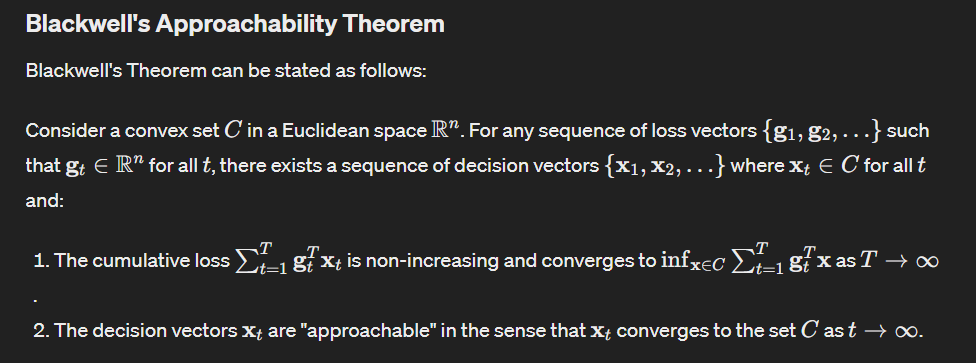

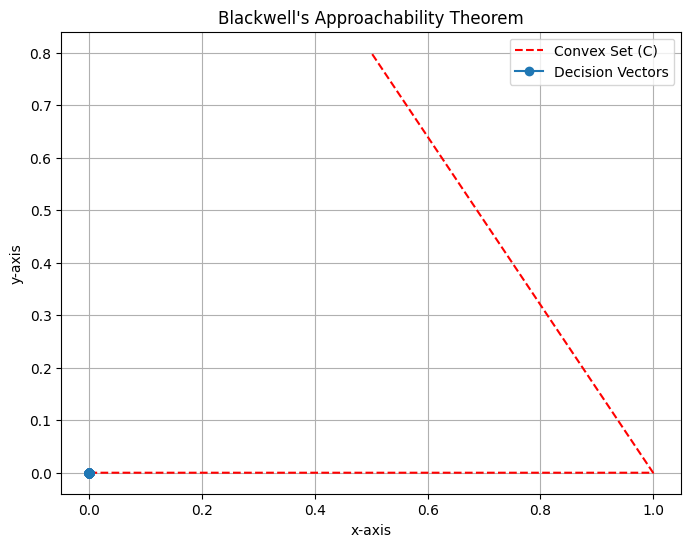

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def blackwell_approachability(convex_set, loss_sequence, learning_rate=0.1, num_iterations=100):
    """
    Simulate Blackwell's approachability theorem in a Euclidean space.

    Args:
    convex_set (numpy.ndarray): Target convex set (C) represented as a numpy array of shape (num_points, dimension).
    loss_sequence (list): Sequence of loss vectors (g_t) represented as a list of numpy arrays with shape (dimension,).
    learning_rate (float): Learning rate for updating decision vectors.
    num_iterations (int): Number of iterations to simulate.

    Returns:
    numpy.ndarray: Array of decision vectors (x_t) over iterations, shape (num_iterations, dimension).
    """

    dimension = convex_set.shape[1]
    decision_vectors = np.zeros((num_iterations + 1, dimension))

    # Initialize the first decision vector within the convex set
    x_t = convex_set[0]  # initial decision vector
    decision_vectors[0] = x_t

    # Simulate Blackwell's approachability
    for t in range(1, num_iterations + 1):
        g_t = loss_sequence[t - 1]  # retrieve loss vector g_t for iteration t

        # Update decision vector x_t based on the gradient of the cumulative loss
        x_t = x_t - learning_rate * g_t
        x_t = convex_projection(x_t, convex_set)  # project onto the convex set

        decision_vectors[t] = x_t

    return decision_vectors

def convex_projection(x, convex_set):
    """
    Project vector x onto a convex set represented by a numpy array of points.

    Args:
    x (numpy.ndarray): Input vector to be projected, shape (dimension,).
    convex_set (numpy.ndarray): Array of points representing the convex set, shape (num_points, dimension).

    Returns:
    numpy.ndarray: Projected vector onto the convex set, shape (dimension,).
    """

    # Find the closest point in the convex set to vector x (projection)
    distances = np.linalg.norm(convex_set - x, axis=1)
    closest_point_index = np.argmin(distances)
    projected_vector = convex_set[closest_point_index]

    return projected_vector

# Example usage
np.random.seed(0)

# Define the target convex set (C) as a triangle in 2D space
convex_set = np.array([
    [0, 0],
    [1, 0],
    [0.5, 0.8]
])

# Generate a sequence of random loss vectors for 2D space
num_iterations = 100
loss_sequence = [np.random.rand(2) for _ in range(num_iterations)]

# Simulate Blackwell's approachability
decision_vectors = blackwell_approachability(convex_set, loss_sequence)

# Plot the trajectory of decision vectors
plt.figure(figsize=(8, 6))
plt.plot(convex_set[:, 0], convex_set[:, 1], 'r--', label='Convex Set (C)')
plt.plot(decision_vectors[:, 0], decision_vectors[:, 1], marker='o', label='Decision Vectors')
plt.title("Blackwell's Approachability Theorem")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.legend()
plt.grid(True)
plt.show()


#Regret Minimization via Approachability

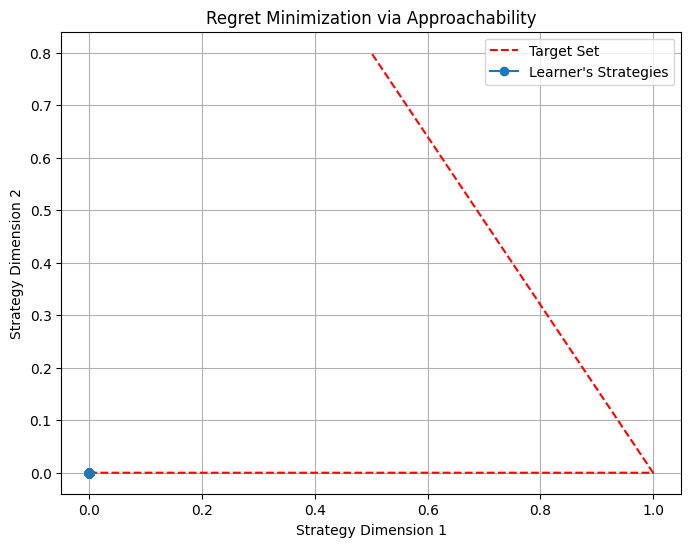

Cumulative Regret: 0.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def regret_minimization_approachability(target_set, loss_sequence, learning_rate=0.1):
    """
    Simulate regret minimization via approachability in an online learning setting.

    Args:
    target_set (numpy.ndarray): Target set (e.g., set of optimal strategies) represented as a numpy array of shape (num_points, dimension).
    loss_sequence (list): Sequence of loss values (feedback) for each round.
    learning_rate (float): Learning rate for updating the learner's strategy.

    Returns:
    numpy.ndarray: Array of learner's strategies over rounds, shape (num_rounds + 1, dimension).
    float: Cumulative regret over the rounds.
    """

    num_rounds = len(loss_sequence)
    dimension = target_set.shape[1]
    learner_strategies = np.zeros((num_rounds + 1, dimension))
    cumulative_regret = 0
    best_fixed_strategy_loss = np.inf

    # Calculate the loss of the best fixed strategy in hindsight
    for x_fixed in target_set:
        fixed_strategy_loss = sum(np.dot(loss_sequence[t], x_fixed) for t in range(num_rounds))
        if fixed_strategy_loss < best_fixed_strategy_loss:
            best_fixed_strategy_loss = fixed_strategy_loss

    # Simulate regret minimization via approachability
    for t in range(1, num_rounds + 1):
        loss_t = loss_sequence[t - 1]

        # Update learner's strategy (approaching the target set)
        x_t = learner_strategies[t - 1]

        # Project loss vector onto the learner's strategy
        learner_loss_t = np.dot(loss_t, x_t)

        # Update cumulative regret
        cumulative_regret += learner_loss_t - best_fixed_strategy_loss

        # Update learner's strategy using gradient descent and projection onto the target set
        x_t = x_t - learning_rate * loss_t
        x_t = convex_projection(x_t, target_set)  # project onto the target set

        learner_strategies[t] = x_t

    return learner_strategies, cumulative_regret

def convex_projection(x, convex_set):
    """
    Project vector x onto a convex set represented by a numpy array of points.

    Args:
    x (numpy.ndarray): Input vector to be projected, shape (dimension,).
    convex_set (numpy.ndarray): Array of points representing the convex set, shape (num_points, dimension).

    Returns:
    numpy.ndarray: Projected vector onto the convex set, shape (dimension,).
    """

    distances = np.linalg.norm(convex_set - x.reshape(1, -1), axis=1)
    closest_point_index = np.argmin(distances)
    projected_vector = convex_set[closest_point_index]

    return projected_vector

# Example usage
np.random.seed(0)

# Define the target set (e.g., set of optimal strategies) as a 2D convex set
target_set = np.array([
    [0, 0],
    [1, 0],
    [0.5, 0.8]
])

# Generate a sequence of random losses for each round
num_rounds = 100
loss_sequence = [np.random.rand(target_set.shape[1]) for _ in range(num_rounds)]

# Simulate regret minimization via approachability
learner_strategies, cumulative_regret = regret_minimization_approachability(target_set, loss_sequence)

# Plot the trajectory of learner's strategies over rounds
plt.figure(figsize=(8, 6))
plt.plot(target_set[:, 0], target_set[:, 1], 'r--', label='Target Set')
plt.plot(learner_strategies[:, 0], learner_strategies[:, 1], marker='o', label='Learner\'s Strategies')
plt.title("Regret Minimization via Approachability")
plt.xlabel("Strategy Dimension 1")
plt.ylabel("Strategy Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

print("Cumulative Regret:", cumulative_regret)